<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI7 Capstone Project - Datasets & EDA


---

## Index

- [Executive Summary](#executive-summary)
- [Model Walk-through](#model-walk-through)
- [Statistical Analysis](#statistical-analysis)
- [Appendix](#appendix)

<a id="executive-summary"></a>
## Executive Summary

### Goals

The Route Analysis Project is intended to provide an additional possible layer of information to route calculations and recommendations and ultimately recommend safer routes for drivers. Most navigation apps and websites focus on providing the shortest and fastest routes for users, taking into consideration distance, time and traffic. However, there’s another factor that might be of higher importance for users depending on city, time and mode of transport: route safety. In cities where driving is the principal method of transportation drivers need a reliable route recommendation that will avoid dangerous areas and roads, especially when the driver follows blindly the routes that navigation systems provide.

### Metrics and findings

This project takes into consideration two datasets: 
- Los Angeles Crime Data from 2010 to 2019: Used to obtain crime data and crime rates for crime risk calculation.
- Los Angeles City Driving Network: Used to obtain the edges (streets), nodes (intersections), directions, distances and travel time.

Both datasets are included in a network analysis that is used to provide routes to get from point A to point B that not only take into consideration the length of the route, but also the added factor of crime rate.

### Risks and challenges

<a id="model-walk-through"></a>
## Model Walk-through

### EDA

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from tqdm import tqdm
from ast import literal_eval
import seaborn as sns
from IPython.display import IFrame
import pickle
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.8.2'

#### Los Angeles Crime Dataset from 2010 to 2019

**Initial Approach**

The first step taken when looking at the crime data to be used is understanding what the dataset includes in terms of size, features, datatypes, null values, among others. It's important to look at the datatype of each feature to make sure it makes sense and is as expected.

The most important features in the dataframe are the following:
- Date Occurred: Provides guidance as to which observations (crimes) are more recent and thus, more relevant.
- Time Occurred: Provides guidance as to which hours of the day are more dangerous and should add weight to the riskyness of certain roads.
- Crime Code Description: Provides guidance regarding the type of crime committed and which should be more relevant when determining the riskyness of a road.
- Location: Provides the location of a committed crime in terms of latitude and longitude and is used for determining which roads are more dangerous than others.

In [232]:
la_crime_2010 = pd.read_csv('/Users/jessicatong/Downloads/Crime_Data_from_2010_to_Present-2.csv')

In [233]:
la_crime_2010.shape

(1893805, 26)

In [234]:
la_crime_2010.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893805 entries, 0 to 1893804
Data columns (total 26 columns):
DR Number                 int64
Date Reported             object
Date Occurred             object
Time Occurred             int64
Area ID                   int64
Area Name                 object
Reporting District        int64
Crime Code                int64
Crime Code Description    object
MO Codes                  object
Victim Age                float64
Victim Sex                object
Victim Descent            object
Premise Code              float64
Premise Description       object
Weapon Used Code          float64
Weapon Description        object
Status Code               object
Status Description        object
Crime Code 1              float64
Crime Code 2              float64
Crime Code 3              float64
Crime Code 4              float64
Address                   object
Cross Street              object
Location                  object
dtypes: float64(7), int64(5

In [235]:
la_crime_2010.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
0,1208575,03/14/2013,03/11/2013,1800,12,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 0446 1243 2000,...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,626.0,NaN,NaN,NaN,6300 BRYNHURST AV,NaN,"(33.9829, -118.3338)"
1,102005556,01/25/2010,01/22/2010,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,VAN NESS,15TH,"(34.0454, -118.3157)"
2,418,03/19/2013,03/18/2013,2030,18,Southeast,1823,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E 104TH ST,NaN,"(33.942, -118.2717)"
3,101822289,11/11/2010,11/10/2010,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,88TH,WALL,"(33.9572, -118.2717)"
4,42104479,01/11/2014,01/04/2014,2300,21,Topanga,2133,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329,...,NaN,IC,Invest Cont,745.0,NaN,NaN,NaN,7200 CIRRUS WY,NaN,"(34.2009, -118.6369)"


In [237]:
la_crime_2010.isnull().sum()

DR Number                       0
Date Reported                   0
Date Occurred                   0
Time Occurred                   0
Area ID                         0
Area Name                       0
Reporting District              0
Crime Code                      0
Crime Code Description        362
MO Codes                   203695
Victim Age                 149361
Victim Sex                 174355
Victim Descent             174397
Premise Code                   84
Premise Description          3232
Weapon Used Code          1261665
Weapon Description        1261666
Status Code                     2
Status Description              0
Crime Code 1                    8
Crime Code 2              1771539
Crime Code 3              1890852
Crime Code 4              1893714
Address                         0
Cross Street              1577680
Location                        9
dtype: int64

As shown above, there are several features of the dataframe that have null values for more than 50% or a significant portion of the observations. These features are not very relevant for the analysis performed in this project so they're removed from the dataframe. The remaining null values represent a very small percentage of total observations (<1%) and belong to features that are essencial for the model (location, crime description, among others) hence they will be dropped so no errors arrise from having null values in the data.

In [238]:
# Drop unnecessary features with null values

la_crime_2010.drop(columns=['MO Codes', 'Victim Age', 'Victim Sex', 'Victim Descent',
                         'Premise Code', 'Premise Description', 'Weapon Used Code',
                         'Weapon Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3', 'Crime Code 4',
                         'Cross Street'],inplace=True)

In [245]:
# Drop remaining observations with null values

la_crime_2010.dropna(inplace=True)

In [246]:
# Check that no null values remain in the dataframe

la_crime_2010.isnull().sum()

dr_number                 0
date_reported             0
date_occurred             0
time_occurred             0
area_id                   0
area_name                 0
reporting_district        0
crime_code                0
crime_code_description    0
status_code               0
status_description        0
address                   0
location                  0
year_occurred             0
dtype: int64

The remaining columns are renamed for easier navigation by replacing spaces with under scores and uppercase letters for lowercase letters.

In [240]:
la_crime_2010.columns=['dr_number', 'date_reported', 'date_occurred', 'time_occurred', 
                       'area_id', 'area_name', 'reporting_district', 'crime_code', 
                       'crime_code_description', 'status_code', 'status_description', 'address', 'location']

A new column is added at the end of the dataframe that contains only the year in which the crime was committed. The purpose of the column is to make the navigation and subsetting of the dataframe easier.

In [242]:
la_crime_2010['year_occurred'] = [int(la_crime_2010.date_occurred[i][-4:]) for i in range(0,len(la_crime_2010))]

In [248]:
# Converting the year_occurred column to integer

la_crime_2010['year_occurred'] = [int(year) for year in la_crime_2010.year_occurred]

In [247]:
la_crime_2010.head()

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,status_code,status_description,address,location,year_occurred
0,1208575,03/14/2013,03/11/2013,1800,12,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,AO,Adult Other,6300 BRYNHURST AV,"(33.9829, -118.3338)",2013
1,102005556,01/25/2010,01/22/2010,2300,20,Olympic,2071,510,VEHICLE - STOLEN,IC,Invest Cont,VAN NESS,"(34.0454, -118.3157)",2010
2,418,03/19/2013,03/18/2013,2030,18,Southeast,1823,510,VEHICLE - STOLEN,IC,Invest Cont,200 E 104TH ST,"(33.942, -118.2717)",2013
3,101822289,11/11/2010,11/10/2010,1800,18,Southeast,1803,510,VEHICLE - STOLEN,IC,Invest Cont,88TH,"(33.9572, -118.2717)",2010
4,42104479,01/11/2014,01/04/2014,2300,21,Topanga,2133,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),IC,Invest Cont,7200 CIRRUS WY,"(34.2009, -118.6369)",2014


In [550]:
la_crime_2010.columns

Index(['dr_number', 'date_reported', 'date_occurred', 'time_occurred',
       'area_id', 'area_name', 'reporting_district', 'crime_code',
       'crime_code_description', 'status_code', 'status_description',
       'address', 'location', 'year_occurred'],
      dtype='object')

In [551]:
la_crime_locations = la_crime_2010.drop(columns=['dr_number', 'date_reported',
       'area_id','status_code', 'status_description','address',])

In [576]:
la_crime_locations['loc'] = [literal_eval(x) for x in la_crime_2010['location']]

In [577]:
la_crime_locations['lat'] = [x for x,y in la_crime_locations['loc']]

In [578]:
la_crime_locations['lon'] = [y for x,y in la_crime_locations['loc']]

In [579]:
la_crime_locations.head()

,date_occurred,time_occurred,area_name,reporting_district,crime_code,crime_code_description,location,year_occurred,loc,lat,lon
0,03/11/2013,1800,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,"(33.9829, -118.3338)",2013,"(33.9829, -118.3338)",33.9829,-118.3338
1,01/22/2010,2300,Olympic,2071,510,VEHICLE - STOLEN,"(34.0454, -118.3157)",2010,"(34.0454, -118.3157)",34.0454,-118.3157
2,03/18/2013,2030,Southeast,1823,510,VEHICLE - STOLEN,"(33.942, -118.2717)",2013,"(33.942, -118.2717)",33.9420,-118.2717
3,11/10/2010,1800,Southeast,1803,510,VEHICLE - STOLEN,"(33.9572, -118.2717)",2010,"(33.9572, -118.2717)",33.9572,-118.2717
4,01/04/2014,2300,Topanga,2133,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),"(34.2009, -118.6369)",2014,"(34.2009, -118.6369)",34.2009,-118.6369


In [580]:
la_crime_locations.to_csv('la_crime_locations.csv')

In [ ]:
# Add graphs to visualize the distribution of crimes in LA, correlation between time/hour of the day and # of crimes

**Subset the dataframe**

The latest dataframe (la_crime_2010) consists of approximately 1.8 million observations, which will be inconvenient for the initial modeling phases since the size of it will cause functions to run extremelly slow. For this reason, subsets of the dataframe have to be created to develop the model and, once the model is finished, apply it to the entire dataset. The dataframe will be subsetted based on two factors: Year in which the crime occured and type of crime committed.

*1. Year of crime committed:*

The crime dataset will be further subset in two groups:

- Crimes committed from 2017 to 2019:

In [249]:
# Subset the dataframe

la_crime_2017 = la_crime_2010[la_crime_2010['year_occurred']>=2017]

In [250]:
# Review number of observations per year

la_crime_2017.year_occurred.value_counts()

2017    230930
2018    225344
2019       986
Name: year_occurred, dtype: int64

In [251]:
# Save the new dataset to a .csv file

la_crime_2017.to_csv('la_crime_2017.csv')

In [264]:

la_crime_2017_new = pd.read_csv('./la_crime_2017.csv')

In [265]:
la_crime_2017_new.head()

,Unnamed: 0,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,status_code,status_description,address,location,year_occurred
0,1308849,170209449,04/22/2017,04/21/2017,1930,2,Rampart,201,510,VEHICLE - STOLEN,IC,Invest Cont,ALEXANDRIA,"(34.0886, -118.2979)",2017
1,1382571,170206243,02/14/2017,02/11/2017,1700,2,Rampart,275,510,VEHICLE - STOLEN,IC,Invest Cont,OLYMPIC,"(34.0512, -118.2787)",2017
2,1383139,170311599,04/25/2017,04/25/2017,745,3,Southwest,325,510,VEHICLE - STOLEN,IC,Invest Cont,VERMONT,"(34.0328, -118.2915)",2017
3,1383420,170408264,04/07/2017,04/07/2017,1,4,Hollenbeck,421,510,VEHICLE - STOLEN,IC,Invest Cont,ALHAMBRA,"(34.0676, -118.2202)",2017
4,1383515,170508584,04/10/2017,04/08/2017,730,5,Harbor,566,510,VEHICLE - STOLEN,IC,Invest Cont,10TH,"(33.7347, -118.2842)",2017


- Crimes committed from 2018 to 2019:

This subset was created since the crime data from 2017 to 2019 subset was too big to add to the network analysis that will be performed.

In [283]:
# Subset the dataframe

la_crime_2018 = la_crime_2010[la_crime_2010['year_occurred']>=2018]

In [284]:
# Review number of observations per year

la_crime_2018.year_occurred.value_counts()

2018    225344
2019       986
Name: year_occurred, dtype: int64

In [286]:
# Save the new dataset to a .csv file

la_crime_2018.to_csv('la_crime_2018.csv')

In [287]:
la_crime_2018_new = pd.read_csv('./la_crime_2018.csv')

In [288]:
la_crime_2018_new.head()

,Unnamed: 0,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,status_code,status_description,address,location,year_occurred
0,1614213,170326543,04/13/2018,04/13/2018,1955,7,Wilshire,776,510,VEHICLE - STOLEN,IC,Invest Cont,LOMITA,"(34.0459, -118.3374)",2018
1,1640525,171616979,02/25/2018,02/25/2018,940,16,Foothill,1698,510,VEHICLE - STOLEN,AO,Adult Other,ARMINTA,"(34.2141, -118.3604)",2018
2,1649274,180404084,01/03/2018,01/01/2018,2200,4,Hollenbeck,461,510,VEHICLE - STOLEN,IC,Invest Cont,1600 E 3RD ST,"(34.0452, -118.223)",2018
3,1649528,181204193,01/03/2018,01/02/2018,1930,12,77th Street,1239,510,VEHICLE - STOLEN,IC,Invest Cont,1100 W 60TH PL,"(33.985, -118.2937)",2018
4,1650014,180104010,01/01/2018,01/01/2018,250,1,Central,157,440,THEFT PLAIN - PETTY ($950 & UNDER),IC,Invest Cont,5TH ST,"(34.0435, -118.2427)",2018


In [ ]:
# Consider adding graphs that show how crimes vary from year to year

*2. Type of crime committed:* 

The crime dataset includes all crimes committed in Los Angeles, California since 2010, not only crimes that are relevant for the analysis of how risky roads really for the purpose of driving. Because of this, all crime descriptions are used to classify the entire dataset into 4 categories:
- crime_risk_0: crime descriptions that have no effect on road safety; assigned risk factor: 0.
- crime_risk_1: crime descriptions that have low impact on road safety; assigned risk factor: 1.
- crime_risk_2: crime descriptions that have medium impact on road safety; assigned risk factor: 2.
- crime_risk_3: crime descriptions that have high impact on road safety; assigned risk factor: 3.

In [311]:
crime_risk_0 = {'crime': ['VANDALISM - MISDEAMEANOR ($399 OR UNDER)','THROWING OBJECT AT MOVING VEHICLE',
                          'OTHER MISCELLANEOUS CRIME','INDECENT EXPOSURE','BOMB SCARE','EXTORTION','DISTURBING THE PEACE',
                          'CRUELTY TO ANIMALS','SEXUAL PENTRATION WITH A FOREIGN OBJECT','THEFT OF IDENTITY',
                          'VIOLATION OF COURT ORDER','LETTERS, LEWD','FALSE IMPRISONMENT','LEWD CONDUCT','PROWLER','PIMPING',
                          'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM0065','PEEPING TOM','SEX, UNLAWFUL',
                          'ORAL COPULATION','THREATENING PHONE CALLS/LETTERS','DISHONEST EMPLOYEE - PETTY THEFT',
                          'UNAUTHORIZED COMPUTER ACCESS','BUNCO, ATTEMPT','BRIBERY','CREDIT CARDS, FRAUD USE ($950 & UNDER',
                          'PICKPOCKET, ATTEMPT','FALSE POLICE REPORT','ABORTION/ILLEGAL','CONTRIBUTING','DISRUPT SCHOOL',
                          'FAILURE TO DISPERSE','CONTEMPT OF COURT','BIGAMY','DOCUMENT WORTHLESS ($200 & UNDER)',
                          'DISHONEST EMPLOYEE ATTEMPTED THEFT','INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
                          'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT','SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ0059',
                          'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
                          'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD','SEXUAL PENETRATION W/FOREIGN OBJECT','STALKING',
                          'DOCUMENT FORGERY / STOLEN FELONY','RESISTING ARREST','COUNTERFEIT',
                          'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)0132',
                          'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER',
                          'CRIMINAL THREATS - NO WEAPON DISPLAYED',
                          'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114',
                          'CHILD NEGLECT (SEE 300 W.I.C.)','CHILD ANNOYING (17YRS & UNDER)',
                          'SEXUAL PENTRATION WITH A FOREIGN OBJECT','PICKPOCKET',
                          'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)0060',
                          'CREDIT CARDS, FRAUD USE ($950.01 & OVER)','SHOPLIFTING - ATTEMPT','ILLEGAL DUMPING',
                          'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)','PURSE SNATCHING - ATTEMPT',
                          'DISHONEST EMPLOYEE - GRAND THEFT','INTIMATE PARTNER - AGGRAVATED ASSAULT',
                          'INTIMATE PARTNER - SIMPLE ASSAULT','DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400',
                          'THEFT, COIN MACHINE - PETTY ($950 & UNDER)','LEWD/LASCIVIOUS ACTS WITH CHILD',
                          'BOAT - STOLEN','INCITING A RIOT','PANDERING','LYNCHING - ATTEMPTED','CONSPIRACY',
                          'CHILD ABANDONMENT','CONTEMPT OF COURT','GRAND THEFT / INSURANCE FRAUD','LYNCHING',
                          'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT','DRUNK ROLL - ATTEMPT','ATTEMPTED ROBBERY',
                          'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH','CHILD PORNOGRAPHY','TRESPASSING',
                          'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)','FIREARMS RESTRAINING ORDER (FIREARMS RO)',
                          'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
                          'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)'],'risk':0}
crime_risk_1 = {'crime': ['SHOPLIFTING - PETTY THEFT ($950 & UNDER)','BIKE - STOLEN','BURGLARY','OTHER ASSAULT',
                          'THEFT PLAIN - ATTEMPT','BRANDISH WEAPON','ARSON','BURGLARY, ATTEMPTED','BUNCO, GRAND THEFT',
                          'BIKE - ATTEMPTED STOLEN','THEFT FROM PERSON - ATTEMPT','DRIVING WITHOUT OWNER CONSENT (DWOC)',
                          'KIDNAPPING - GRAND ATTEMPT','RECKLESS DRIVING','TRAIN WRECKING','DRUGS, TO A MINOR',
                          'TELEPHONE PROPERTY - DAMAGE','TILL TAP - ATTEMPT','THEFT, COIN MACHINE - ATTEMPT',
                          'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
                          'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH 0007=02'],'risk':1}
crime_risk_2 = {'crime': ['THEFT PLAIN - PETTY ($950 & UNDER)','BATTERY - SIMPLE ASSAULT','ROBBERY',
                          'BURGLARY FROM VEHICLE','TILL TAP - PETTY ($950 & UNDER)',
                          'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)','THEFT, PERSON','BATTERY POLICE (SIMPLE)',
                          'BURGLARY FROM VEHICLE, ATTEMPTED','KIDNAPPING','CHILD STEALING',
                          'WEAPONS POSSESSION/BOMBING','DRUNK ROLL','VEHICLE - ATTEMPT STOLEN',
                          'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)','PETTY THEFT - AUTO REPAIR'],'risk':2}
crime_risk_3 = {'crime': ['VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
                          'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036', 
                          'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT','BATTERY WITH SEXUAL CONTACT',
                          'RAPE, FORCIBLE','THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
                          'SHOTS FIRED AT INHABITED DWELLING','THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
                          'DISCHARGE FIREARMS/SHOTS FIRED','ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
                          'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT','GRAND THEFT / AUTO REPAIR',
                          'MANSLAUGHTER, NEGLIGENT','TILL TAP - GRAND THEFT ($950.01 & OVER)',
                          'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD','VEHICLE - STOLEN',
                          'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE','HUMAN TRAFFICKING - COMMERCIAL SEX ACTS'],'risk':3}

In [312]:
# With a for loop, add a column to each of the dataframes (2017 and 2018) that includes the risk level per 
# crime committed.

crime_risk_list = []
for crime in tqdm(la_crime_2017_new['crime_code_description']):
    if crime in crime_risk_0['crime']:
        crime_risk_list.append(crime_risk_0['risk'])
    elif crime in crime_risk_1['crime']:
        crime_risk_list.append(crime_risk_1['risk'])
    elif crime in crime_risk_2['crime']:
        crime_risk_list.append(crime_risk_2['risk'])
    elif crime in crime_risk_3['crime']:
        crime_risk_list.append(crime_risk_3['risk'])
    else:
        crime_risk_list.append(crime_risk_1['risk'])
la_crime_2017_new['crime_risk'] = crime_risk_list











  0%|          | 0/457260 [00:00<?, ?it/s]









  0%|          | 1/457260 [00:00<90:11:23,  1.41it/s]









  6%|▋         | 28995/457260 [00:00<59:07:47,  2.01it/s]









 16%|█▌        | 72440/457260 [00:00<37:11:31,  2.87it/s]









 24%|██▍       | 110339/457260 [00:01<23:28:14,  4.11it/s]









 35%|███▌      | 160481/457260 [00:01<14:03:17,  5.87it/s]









 46%|████▋     | 211700/457260 [00:01<8:08:25,  8.38it/s] 









 57%|█████▋    | 261539/457260 [00:01<4:32:30, 11.97it/s]









 67%|██████▋   | 305432/457260 [00:01<2:27:58, 17.10it/s]









 78%|███████▊  | 355968/457260 [00:01<1:09:06, 24.43it/s]









 89%|████████▊ | 405641/457260 [00:01<24:39, 34.90it/s]  









100%|██████████| 457260/457260 [00:01<00:00, 267659.10it/s]

In [313]:
la_crime_2017_risk = la_crime_2017_new[la_crime_2017_new['crime_risk'] >= 1]

In [314]:
len(la_crime_2017_risk)

319066

In [315]:
la_crime_2017_risk.to_csv('la_crime_2017_fv.csv')

In [296]:
la_crime_2018_new.crime_risk.value_counts()

2    83986
0    62674
1    43572
3    36098
Name: crime_risk, dtype: int64

In [588]:
la_crime_2018_risk2 = la_crime_2018_new[la_crime_2018_new['crime_risk'] >= 1]

In [589]:
la_crime_2018_risk2.to_csv('la_crime_2018_fv2.csv')

In [590]:
la_crime_2018_risk2.tail()

,Unnamed: 0,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,status_code,status_description,address,location,year_occurred,crime_risk
226324,1893799,192104096,01/03/2019,12/04/2018,1335,21,Topanga,2177,440,THEFT PLAIN - PETTY ($950 & UNDER),IC,Invest Cont,5700 OWENSMOUTH AV,"(34.1744, -118.6016)",2018,2
226325,1893800,192104101,01/03/2019,01/03/2019,500,21,Topanga,2103,310,BURGLARY,IC,Invest Cont,22400 MALDEN ST,"(34.2236, -118.6158)",2019,1
226326,1893801,192104103,01/03/2019,01/03/2019,446,21,Topanga,2134,310,BURGLARY,IC,Invest Cont,22200 SHERMAN WY,"(34.201, -118.6103)",2019,1
226327,1893802,192104105,01/03/2019,01/03/2019,1905,21,Topanga,2189,310,BURGLARY,IC,Invest Cont,20000 WELLS DR,"(34.1648, -118.5771)",2019,1
226328,1893803,192104109,01/04/2019,01/04/2019,700,21,Topanga,2129,440,THEFT PLAIN - PETTY ($950 & UNDER),IC,Invest Cont,19800 STAGG ST,"(34.2108, -118.5648)",2019,2


In [591]:
la_crime_2018_risk2.columns

Index(['Unnamed: 0', 'dr_number', 'date_reported', 'date_occurred',
       'time_occurred', 'area_id', 'area_name', 'reporting_district',
       'crime_code', 'crime_code_description', 'status_code',
       'status_description', 'address', 'location', 'year_occurred',
       'crime_risk'],
      dtype='object')

In [592]:
la_crime_locations = la_crime_2018_risk2.drop(columns=['Unnamed: 0', 'dr_number', 'date_reported', 'date_occurred',
       'time_occurred', 'reporting_district', 'status_code',
       'status_description', 'address', 'nearest_node', 'node_only', 'distance_only'])

KeyError: "labels ['nearest_node' 'node_only' 'distance_only'] not contained in axis"

In [583]:
la_crime_locations['loc'] = [literal_eval(x) for x in la_crime_2018_risk2['location']]

In [584]:
la_crime_locations['lat'] = [x for x,y in la_crime_locations['loc']]

In [585]:
la_crime_locations['lon'] = [y for x,y in la_crime_locations['loc']]

In [586]:
la_crime_locations.head()

,area_id,area_name,crime_code,crime_code_description,location,year_occurred,crime_risk,loc,lat,lon
0,7,Wilshire,510,VEHICLE - STOLEN,"(34.0459, -118.3374)",2018,2,"(34.0459, -118.3374)",34.0459,-118.3374
1,16,Foothill,510,VEHICLE - STOLEN,"(34.2141, -118.3604)",2018,2,"(34.2141, -118.3604)",34.2141,-118.3604
2,4,Hollenbeck,510,VEHICLE - STOLEN,"(34.0452, -118.223)",2018,2,"(34.0452, -118.223)",34.0452,-118.2230
3,12,77th Street,510,VEHICLE - STOLEN,"(33.985, -118.2937)",2018,2,"(33.985, -118.2937)",33.9850,-118.2937
4,1,Central,440,THEFT PLAIN - PETTY ($950 & UNDER),"(34.0435, -118.2427)",2018,2,"(34.0435, -118.2427)",34.0435,-118.2427


In [587]:
la_crime_locations.to_csv('la_crime_locations.csv')

In [ ]:
la_crime_locations = la_crime_2010.drop(columns=['dr_number', 'date_reported',
       'area_id','status_code', 'status_description','address',])

la_crime_locations['loc'] = [literal_eval(x) for x in la_crime_2010['location']]

la_crime_locations['lat'] = [x for x,y in la_crime_locations['loc']]

la_crime_locations['lon'] = [y for x,y in la_crime_locations['loc']]

la_crime_locations.head()

la_crime_locations.to_csv('la_crime_locations.csv')

#### Los Angeles Road Network

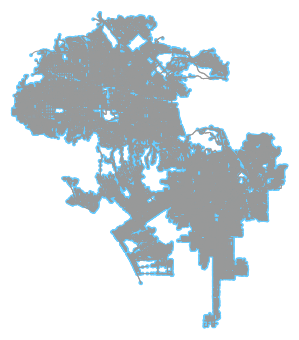

In [3]:
LA = ox.graph_from_place('Los Angeles, California, USA', network_type='drive')
fig, ax = ox.plot_graph(LA)

In [340]:
LA_network = pd.DataFrame(list(LA.edges()),columns=['start_node','end_node'])

In [341]:
LA_network['edge'] = [(LA_network.start_node[i],LA_network.end_node[i]) for i in range(0,len(LA_network))]

In [345]:
LA_network['edge_crime'] = (LA_network['start_node_weight'] + LA_network['end_node_weight'])/2

In [343]:
LA_network['start_node_weight'] = 1

In [344]:
LA_network['end_node_weight'] = 1

In [346]:
LA_network.head()

,start_node,end_node,edge,edge_crime,start_node_weight,end_node_weight
0,122814468,122814472,"(122814468, 122814472)",1.0,1,1
1,122814468,123152289,"(122814468, 123152289)",1.0,1,1
2,122814468,122659220,"(122814468, 122659220)",1.0,1,1
3,1842872326,1842872352,"(1842872326, 1842872352)",1.0,1,1
4,1842872326,1842872317,"(1842872326, 1842872317)",1.0,1,1


In [ ]:
<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI7 Capstone Project - Findings & Technical Report


---

## Index

- [Executive Summary](#executive-summary)
- [Model Walk-through](#model-walk-through)
- [Statistical Analysis](#statistical-analysis)
- [Appendix](#appendix)

<a id="executive-summary"></a>
## Executive Summary

### Goals

The Route Analysis Project is intended to provide an additional possible layer of information to route calculations and recommendations and ultimately recommend safer routes for drivers. Most navigation apps and websites focus on providing the shortest and fastest routes for users, taking into consideration distance, time and traffic. However, there’s another factor that might be of higher importance for users depending on city, time and mode of transport: route safety. In cities where driving is the principal method of transportation drivers need a reliable route recommendation that will avoid dangerous areas and roads, especially when the driver follows blindly the routes that navigation systems provide.

### Metrics and findings

This project takes into consideration two datasets: 
- Los Angeles Crime Data from 2010 to 2019: Used to obtain crime data and crime rates for crime risk calculation.
- Los Angeles City Driving Network: Used to obtain the edges (streets), nodes (intersections), directions, distances and travel time.

Both datasets are included in a network analysis that is used to provide routes to get from point A to point B that not only take into consideration the length of the route, but also the added factor of crime rate.

### Risks and challenges



<a id="model-walk-through"></a>
## Model Walk-through

### EDA

import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from tqdm import tqdm
from ast import literal_eval
import seaborn as sns
from IPython.display import IFrame
import pickle
ox.config(use_cache=True, log_console=True)
ox.__version__

#### Los Angeles Crime Dataset from 2010 to 2019

**Initial Approach**

The first step taken when looking at the crime data to be used is understanding what the dataset includes in terms of size, features, datatypes, null values, among others. It's important to look at the datatype of each feature to make sure it makes sense and is as expected.

The most important features in the dataframe are the following:
- Date Occurred: Provides guidance as to which observations (crimes) are more recent and thus, more relevant.
- Time Occurred: Provides guidance as to which hours of the day are more dangerous and should add weight to the riskyness of certain roads.
- Crime Code Description: Provides guidance regarding the type of crime committed and which should be more relevant when determining the riskyness of a road.
- Location: Provides the location of a committed crime in terms of latitude and longitude and is used for determining which roads are more dangerous than others.

la_crime_2010 = pd.read_csv('/Users/jessicatong/Downloads/Crime_Data_from_2010_to_Present-2.csv')

la_crime_2010.shape

la_crime_2010.info()

la_crime_2010.head()

la_crime_2010.isnull().sum()

As shown above, there are several features of the dataframe that have null values for more than 50% or a significant portion of the observations. These features are not very relevant for the analysis performed in this project so they're removed from the dataframe. The remaining null values represent a very small percentage of total observations (<1%) and belong to features that are essencial for the model (location, crime description, among others) hence they will be dropped so no errors arrise from having null values in the data.

# Drop unnecessary features with null values

la_crime_2010.drop(columns=['MO Codes', 'Victim Age', 'Victim Sex', 'Victim Descent',
                         'Premise Code', 'Premise Description', 'Weapon Used Code',
                         'Weapon Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3', 'Crime Code 4',
                         'Cross Street'],inplace=True)

# Drop remaining observations with null values

la_crime_2010.dropna(inplace=True)

# Check that no null values remain in the dataframe

la_crime_2010.isnull().sum()

The remaining columns are renamed for easier navigation by replacing spaces with under scores and uppercase letters for lowercase letters.

la_crime_2010.columns=['dr_number', 'date_reported', 'date_occurred', 'time_occurred', 
                       'area_id', 'area_name', 'reporting_district', 'crime_code', 
                       'crime_code_description', 'status_code', 'status_description', 'address', 'location']

A new column is added at the end of the dataframe that contains only the year in which the crime was committed. The purpose of the column is to make the navigation and subsetting of the dataframe easier.

la_crime_2010['year_occurred'] = [int(la_crime_2010.date_occurred[i][-4:]) for i in range(0,len(la_crime_2010))]

# Converting the year_occurred column to integer

la_crime_2010['year_occurred'] = [int(year) for year in la_crime_2010.year_occurred]

la_crime_2010.head()

la_crime_2010.columns

la_crime_locations = la_crime_2010.drop(columns=['dr_number', 'date_reported',
       'area_id','status_code', 'status_description','address',])

la_crime_locations['loc'] = [literal_eval(x) for x in la_crime_2010['location']]

la_crime_locations['lat'] = [x for x,y in la_crime_locations['loc']]

la_crime_locations['lon'] = [y for x,y in la_crime_locations['loc']]

la_crime_locations.head()

la_crime_locations.to_csv('la_crime_locations.csv')

# Add graphs to visualize the distribution of crimes in LA, correlation between time/hour of the day and # of crimes

**Subset the dataframe**

The latest dataframe (la_crime_2010) consists of approximately 1.8 million observations, which will be inconvenient for the initial modeling phases since the size of it will cause functions to run extremelly slow. For this reason, subsets of the dataframe have to be created to develop the model and, once the model is finished, apply it to the entire dataset. The dataframe will be subsetted based on two factors: Year in which the crime occured and type of crime committed.

*1. Year of crime committed:*

The crime dataset will be further subset in two groups:

- Crimes committed from 2017 to 2019:

# Subset the dataframe

la_crime_2017 = la_crime_2010[la_crime_2010['year_occurred']>=2017]

# Review number of observations per year

la_crime_2017.year_occurred.value_counts()

# Save the new dataset to a .csv file

la_crime_2017.to_csv('la_crime_2017.csv')


la_crime_2017_new = pd.read_csv('./la_crime_2017.csv')

la_crime_2017_new.head()

- Crimes committed from 2018 to 2019:

This subset was created since the crime data from 2017 to 2019 subset was too big to add to the network analysis that will be performed.

# Subset the dataframe

la_crime_2018 = la_crime_2010[la_crime_2010['year_occurred']>=2018]

# Review number of observations per year

la_crime_2018.year_occurred.value_counts()

# Save the new dataset to a .csv file

la_crime_2018.to_csv('la_crime_2018.csv')

la_crime_2018_new = pd.read_csv('./la_crime_2018.csv')

la_crime_2018_new.head()

# Consider adding graphs that show how crimes vary from year to year

*2. Type of crime committed:* 

The crime dataset includes all crimes committed in Los Angeles, California since 2010, not only crimes that are relevant for the analysis of how risky roads really for the purpose of driving. Because of this, all crime descriptions are used to classify the entire dataset into 4 categories:
- crime_risk_0: crime descriptions that have no effect on road safety; assigned risk factor: 0.
- crime_risk_1: crime descriptions that have low impact on road safety; assigned risk factor: 1.
- crime_risk_2: crime descriptions that have medium impact on road safety; assigned risk factor: 2.
- crime_risk_3: crime descriptions that have high impact on road safety; assigned risk factor: 3.

crime_risk_0 = {'crime': ['VANDALISM - MISDEAMEANOR ($399 OR UNDER)','THROWING OBJECT AT MOVING VEHICLE',
                          'OTHER MISCELLANEOUS CRIME','INDECENT EXPOSURE','BOMB SCARE','EXTORTION','DISTURBING THE PEACE',
                          'CRUELTY TO ANIMALS','SEXUAL PENTRATION WITH A FOREIGN OBJECT','THEFT OF IDENTITY',
                          'VIOLATION OF COURT ORDER','LETTERS, LEWD','FALSE IMPRISONMENT','LEWD CONDUCT','PROWLER','PIMPING',
                          'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM0065','PEEPING TOM','SEX, UNLAWFUL',
                          'ORAL COPULATION','THREATENING PHONE CALLS/LETTERS','DISHONEST EMPLOYEE - PETTY THEFT',
                          'UNAUTHORIZED COMPUTER ACCESS','BUNCO, ATTEMPT','BRIBERY','CREDIT CARDS, FRAUD USE ($950 & UNDER',
                          'PICKPOCKET, ATTEMPT','FALSE POLICE REPORT','ABORTION/ILLEGAL','CONTRIBUTING','DISRUPT SCHOOL',
                          'FAILURE TO DISPERSE','CONTEMPT OF COURT','BIGAMY','DOCUMENT WORTHLESS ($200 & UNDER)',
                          'DISHONEST EMPLOYEE ATTEMPTED THEFT','INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
                          'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT','SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ0059',
                          'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
                          'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD','SEXUAL PENETRATION W/FOREIGN OBJECT','STALKING',
                          'DOCUMENT FORGERY / STOLEN FELONY','RESISTING ARREST','COUNTERFEIT',
                          'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)0132',
                          'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER',
                          'CRIMINAL THREATS - NO WEAPON DISPLAYED',
                          'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114',
                          'CHILD NEGLECT (SEE 300 W.I.C.)','CHILD ANNOYING (17YRS & UNDER)',
                          'SEXUAL PENTRATION WITH A FOREIGN OBJECT','PICKPOCKET',
                          'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)0060',
                          'CREDIT CARDS, FRAUD USE ($950.01 & OVER)','SHOPLIFTING - ATTEMPT','ILLEGAL DUMPING',
                          'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)','PURSE SNATCHING - ATTEMPT',
                          'DISHONEST EMPLOYEE - GRAND THEFT','INTIMATE PARTNER - AGGRAVATED ASSAULT',
                          'INTIMATE PARTNER - SIMPLE ASSAULT','DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400',
                          'THEFT, COIN MACHINE - PETTY ($950 & UNDER)','LEWD/LASCIVIOUS ACTS WITH CHILD',
                          'BOAT - STOLEN','INCITING A RIOT','PANDERING','LYNCHING - ATTEMPTED','CONSPIRACY',
                          'CHILD ABANDONMENT','CONTEMPT OF COURT','GRAND THEFT / INSURANCE FRAUD','LYNCHING',
                          'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT','DRUNK ROLL - ATTEMPT','ATTEMPTED ROBBERY',
                          'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH','CHILD PORNOGRAPHY','TRESPASSING',
                          'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)','FIREARMS RESTRAINING ORDER (FIREARMS RO)',
                          'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
                          'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)'],'risk':0}
crime_risk_1 = {'crime': ['SHOPLIFTING - PETTY THEFT ($950 & UNDER)','BIKE - STOLEN','BURGLARY','OTHER ASSAULT',
                          'THEFT PLAIN - ATTEMPT','BRANDISH WEAPON','ARSON','BURGLARY, ATTEMPTED','BUNCO, GRAND THEFT',
                          'BIKE - ATTEMPTED STOLEN','THEFT FROM PERSON - ATTEMPT','DRIVING WITHOUT OWNER CONSENT (DWOC)',
                          'KIDNAPPING - GRAND ATTEMPT','RECKLESS DRIVING','TRAIN WRECKING','DRUGS, TO A MINOR',
                          'TELEPHONE PROPERTY - DAMAGE','TILL TAP - ATTEMPT','THEFT, COIN MACHINE - ATTEMPT',
                          'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
                          'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH 0007=02'],'risk':1}
crime_risk_2 = {'crime': ['THEFT PLAIN - PETTY ($950 & UNDER)','BATTERY - SIMPLE ASSAULT','ROBBERY',
                          'BURGLARY FROM VEHICLE','TILL TAP - PETTY ($950 & UNDER)',
                          'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)','THEFT, PERSON','BATTERY POLICE (SIMPLE)',
                          'BURGLARY FROM VEHICLE, ATTEMPTED','KIDNAPPING','CHILD STEALING',
                          'WEAPONS POSSESSION/BOMBING','DRUNK ROLL','VEHICLE - ATTEMPT STOLEN',
                          'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)','PETTY THEFT - AUTO REPAIR'],'risk':2}
crime_risk_3 = {'crime': ['VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
                          'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036', 
                          'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT','BATTERY WITH SEXUAL CONTACT',
                          'RAPE, FORCIBLE','THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
                          'SHOTS FIRED AT INHABITED DWELLING','THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
                          'DISCHARGE FIREARMS/SHOTS FIRED','ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
                          'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT','GRAND THEFT / AUTO REPAIR',
                          'MANSLAUGHTER, NEGLIGENT','TILL TAP - GRAND THEFT ($950.01 & OVER)',
                          'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD','VEHICLE - STOLEN',
                          'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE','HUMAN TRAFFICKING - COMMERCIAL SEX ACTS'],'risk':3}

# With a for loop, add a column to each of the dataframes (2017 and 2018) that includes the risk level per 
# crime committed.

crime_risk_list = []
for crime in tqdm(la_crime_2017_new['crime_code_description']):
    if crime in crime_risk_0['crime']:
        crime_risk_list.append(crime_risk_0['risk'])
    elif crime in crime_risk_1['crime']:
        crime_risk_list.append(crime_risk_1['risk'])
    elif crime in crime_risk_2['crime']:
        crime_risk_list.append(crime_risk_2['risk'])
    elif crime in crime_risk_3['crime']:
        crime_risk_list.append(crime_risk_3['risk'])
    else:
        crime_risk_list.append(crime_risk_1['risk'])
la_crime_2017_new['crime_risk'] = crime_risk_list

la_crime_2017_risk = la_crime_2017_new[la_crime_2017_new['crime_risk'] >= 1]

len(la_crime_2017_risk)

la_crime_2017_risk.to_csv('la_crime_2017_fv.csv')

la_crime_2018_new.crime_risk.value_counts()

la_crime_2018_risk2 = la_crime_2018_new[la_crime_2018_new['crime_risk'] >= 1]

la_crime_2018_risk2.to_csv('la_crime_2018_fv2.csv')

la_crime_2018_risk2.tail()

la_crime_2018_risk2.columns

la_crime_locations = la_crime_2018_risk2.drop(columns=['Unnamed: 0', 'dr_number', 'date_reported', 'date_occurred',
       'time_occurred', 'reporting_district', 'status_code',
       'status_description', 'address', 'nearest_node', 'node_only', 'distance_only'])

la_crime_locations['loc'] = [literal_eval(x) for x in la_crime_2018_risk2['location']]

la_crime_locations['lat'] = [x for x,y in la_crime_locations['loc']]

la_crime_locations['lon'] = [y for x,y in la_crime_locations['loc']]

la_crime_locations.head()

la_crime_locations.to_csv('la_crime_locations.csv')

la_crime_locations = la_crime_2010.drop(columns=['dr_number', 'date_reported',
       'area_id','status_code', 'status_description','address',])

la_crime_locations['loc'] = [literal_eval(x) for x in la_crime_2010['location']]

la_crime_locations['lat'] = [x for x,y in la_crime_locations['loc']]

la_crime_locations['lon'] = [y for x,y in la_crime_locations['loc']]

la_crime_locations.head()

la_crime_locations.to_csv('la_crime_locations.csv')



#### Los Angeles Road Network

LA = ox.graph_from_place('Los Angeles, California, USA', network_type='drive')
fig, ax = ox.plot_graph(LA)

LA_network = pd.DataFrame(list(LA.edges()),columns=['start_node','end_node'])

LA_network['edge'] = [(LA_network.start_node[i],LA_network.end_node[i]) for i in range(0,len(LA_network))]

LA_network['edge_crime'] = (LA_network['start_node_weight'] + LA_network['end_node_weight'])/2

LA_network['start_node_weight'] = 1

LA_network['end_node_weight'] = 1

LA_network.head()